<a id='top'></a>

# Contents

- <a href='#import'>Import &amp; Inspect</a> 
- <a href='#fselect'>Feauture Selection</a> 
- <a href='#compare'>Model Comparison &amp; Selection</a> 
   - <a href='#baseline'>Baseline Model</a> 
   - <a href='#linearmodels'>Linear Models</a> 
   - <a href='#nonlinearmodels'>Non-Linear Models</a> 
   - <a href='#treemodels'>Tree Based Models</a>
- <a href='#defaultmodels'>Best Models with Default Parameters</a> 
- <a href='#tuning'>Hyper Parameter Tuning</a> 
- <a href='#bestmodel'>Evaluate the Best Model</a> 
- <a href='#interpretation'>Interpration of Results</a> 
- <a href='#tuning'>Hyper Parameter Tuning</a> 
- <a href='#conclusion'>Conlusion and Documentation</a> 

    
<br>

---


# Predicting Dementia - Machine Learning Analysis
Memory loss based illnesses can cause death of the patient if not discovered early and treated properly. Moreover, medical expenses of demented patients are way higher than medical expenses due to other health issues in elderly people. [Study](http://act.alz.org/site/DocServer/2012_Costs_Fact_Sheet_version_2.pdf?docID=7161) shows that the Medicare spending per person is about $\$ 7415$ for seniors without Alzheimer's and other types of dementia whereas it is about $\$ 24,122$ per person in seniors with other diseases. 

In this project, we will work with the data collected from a longitudinal study on determining cognitive functionality performance of subject. **The objective is to build a model that can classify cognitve impairment(being demented) successfully and interpret the results to find factors which influence the score.**

The data includes the CDR score, which make this a supervised machine learning task. However, since the scores are to classify the stage of the dementia we will work on a supervised classification setting. In other words, our CDR score is a ordinal data so we treat this task as a classification problem to determine which class a subject falls into.

While there is currently no cure for AD, early, accurate and effective detection of AD is beneficial
for the management of the disease. Structural magnetic resonance imaging (sMRI) plays an important role in distinguishing AD subjects from normal controls (NC), and to distinguish mild cognitive impairment (MCI) subjects who
later convert to AD from those who do not.


# Data Wrangling
The [Data Wrangling]() notebook contains the following work:

Import and inspect raw training data. Isolate relevant variables, fill or calculate new variables, and organize the dataframe. Resolve missing, invalid, corrupted or duplicate values.

From that notebook, the clean dataframe was saved in the file `oasis_long.csv`, which is used for EDA.


---
# Exploratory Data Analysis
The [Exploratory Data Analysis]() notebook contains the following work:

Create data visualizations to explain variables. Detect and possibly remove or mark outliers. Explore variable dependence and correlations. Consider a hypothesis to explore. Leverage statistical inference to test the hypothesis. More generally, begin to develop a preliminary likeness of the solution

---
# Machine Learning Analysis
The `oasis_long.csv` file saved at the end of EDA is used here to train the models.

Build, fit, and validate a method to model the data. Evaluate the performance of each model tested, including Logistic Regression, Random Forest, Random Forest, XGBoost.

<a href='#top' id='import'>back to menu</a>

## Import and Load

In [2]:
# Pandas and numpy for data manipulation
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
%matplotlib inline
plt.style.use('fivethirtyeight')

# Internal ipython tool for setting figure size

# Seaborn for visualization
#sns.set(font_scale = 2)

# Splitting data into training and testing

In [3]:
df = pd.read_csv('oasis_long.csv')

<a href='#top' id='fselect'>back to menu</a>

## Feature Engineering and Selection

>Be mindful about `data leakage` here! As our response values are labeled with the `Group` values we should only keep one of them in the dataset. What is the `data leakage`?
>
> Data Leakage is 
>
> To prevent data leakage we must either remove `CDR` or `Groups(Diagnosis)` variable as `Groups` is just encoded version of `CDR`. 

Features needs some work:
- Drop features that are highly-correlated **when using linear alogrithms**
- Drop duplicate columns
- Drop CDR score and use Group to as they are representing the same thing. In this problem, we are not trying to predict what CDR score level could be.
- Drop MRI ID and Subject ID 


In [4]:
# Remove one of the columns of those are highly-correlated and duplicated ones
p_df = df.drop(['MMSE', 'SES','Subject ID', 'MRI ID', 'CDR'], axis=1).copy()

# Rename Columns
name_map = {
            'M/F': 'Gender',
            'MMSE_filled': 'MMSE',
            'SES_filled' : 'SES',
            'Group': 'Diagnosis',
            'EDUC': 'Edu'
}
p_df.rename(name_map, axis=1, inplace=True)
p_df.head()

,Diagnosis,Visit,MR Delay,Gender,Age,Edu,eTIV,nWBV,ASF,MMSE,SES
0,Nondemented,1,0,0,87,14,1987,0.696,0.883,27,4
1,Nondemented,2,457,0,88,14,2004,0.681,0.876,30,4
2,Demented,1,0,0,75,12,1678,0.736,1.046,23,4
3,Demented,2,560,0,76,12,1738,0.713,1.010,28,4
4,Demented,3,1895,0,80,12,1698,0.701,1.034,22,4


In [5]:
p_df.dtypes

Diagnosis     object
Visit          int64
MR Delay       int64
Gender         int64
Age            int64
Edu            int64
eTIV           int64
nWBV         float64
ASF          float64
MMSE           int64
SES            int64
dtype: object

In [6]:
# Define target feature 
target = (p_df['Diagnosis']=='Demented').values

# Predictors
predictors_df = p_df.drop(columns=['Diagnosis'])

In [7]:
predictors_df.dtypes

Visit         int64
MR Delay      int64
Gender        int64
Age           int64
Edu           int64
eTIV          int64
nWBV        float64
ASF         float64
MMSE          int64
SES           int64
dtype: object

## Split Data into Test and Training using Stratified K-Fold

>Stratification is the process of rearranging the data so as to ensure that each fold is a good representative of the whole. For example, in a binary classification problem where each class comprises of 50% of the data, it is best to arrange the data such that in every fold, each class comprises of about half the instances.
>
>It is generally a better approach when dealing with both bias and variance. A randomly selected fold might not adequately represent the minor class, particularly in cases where there is a huge class imbalance. 

In [8]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, random_state=42)

for train, test in skf.split(predictors_df.values, target):
    x_train, x_test = predictors_df.values[train], predictors_df.values[test]
    y_train, y_test = target[train], target[test]

In [9]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(250, 10)
(123, 10)
(250,)
(123,)


<a href='#top' id='compare'>back to menu</a>

## Set Evaluation Metric and Compare ML Models

[Taken From Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix)
![Confusion Matrix](ConfusionMatrix.png)


> For our problem getting False Positive (Non Demented Subject predicted as Demented) is more acceptable than getting False Negative( Demented subject predicted as NonDemented). We can optimize our model for **Sensitivity(Recall)**.
**How sensitive is the classifier to detecting positive instances?** In our case it is Demented subject. The recall is intuitively the ability of the classifier to find all the positive samples or samples of interest. However, keep in mind that while Recall is inreasing we loose from Precision so there is a good trade off. Low Precision will result in detecting Demented subjects incorrectly or increase in False Positive which means here to diagnose healthy subject as Demented! Therefore as a first option  we may want to optimize our model as to create a balanced classification model with an optimal balance of Recall and Precision so we want to **maximize F1 score.**
>
>We can also check **Diagnostic Odds Ratio** out as well which measures the effectiveness of a diagnostic test. It is defined as the ratio of the odds of the test being positive if the subject has a disease relative to the odds of the test being positive if the subject does not have the disease. The diagnostic odds ratio ranges from zero to infinity, although **for useful tests it is greater than one**, and higher diagnostic odds ratios are indicative of better test performance. Diagnostic odds ratios less than one indicate that the test can be improved by simply inverting the outcome of the test – the test is in the wrong direction, while a diagnostic odds ratio of exactly one means that the test is equally likely to predict a positive outcome whatever the true condition – the test gives no information. [source](https://en.wikipedia.org/wiki/Diagnostic_odds_ratio)

$$Recall==Sensitivity = \frac{TP}{TP+FN}$$

---
$$Precision = \frac{TP}{TP+FP}$$

---
$$ F_1 = 2* \frac{Precision*Recall}{Precision+Recall}$$

---


$$ DOR = \frac{TP / FP}{FN / TN} $$


In [10]:
# Define DOR metric function

def dor_metric(c_matrix):
    '''Returns Diagnostics Odds Ratio Score'''
    
    # if FP and FN are 0 add a small value to Confusion Matrix
    if (c_matrix[0][1] and c_matrix[1][0]) == 0:
        c_matrix = c_matrix + np.full((2,2), .0001)
    else:
        c_matrix = c_matrix
    
    # Get the data
    TN = c_matrix[0][0]
    FP = c_matrix[0][1]
    FN = c_matrix[1][0]
    TP = c_matrix[1][1]
    
    dor = (float(TP)/float(FP))/(float(FN)/float(TN))
    return dor

In [11]:
# Make Classification and return reports

def make_classifications(classifiers):
    '''Runs Models and Returns Metrics Results'''
    
    # Figure size spefication
    plt.figure(figsize=(12,8))
    
    fitted_models = []
    dor_scores = {}
    
    # Fit models
    for name, (line_for, model) in classifiers.items():
        model.fit(x_train, y_train)
        fitted_models.append(model)
    
        # Predicted class probabilities
        y_pred_probs = model.predict_proba(x_test)
        demented_class_probs = pd.Series(y_pred_probs[:,1])
        y_pred_classes = model.predict(x_test)
        
        # Get reports
        fpr, tpr, thresholds = roc_curve(y_test, demented_class_probs)
        auc_score = auc(fpr, tpr)
        labels = '%s: auc=%f' %(name, auc_score)
        plt.plot(fpr, tpr, line_for, linewidth=5, label=labels, alpha=.45)
    
        # Print Scores
        print('Accuracy on training: {} with using {}'.format(model.score(x_train, y_train), name))
        print('Accuracy on testing: {} with using {}'.format(model.score(x_test, y_test), name))

        # Classification metrics 
        target_names = ['NonDemented', 'Demented']
        print(classification_report(y_test, y_pred_classes, target_names=target_names))
    
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_classes)
            
        # Compute DOR metric and store it in the dictionary along with accuracy scores
        dor = dor_metric(cm)
        dor_scores[name] = [dor, model.score(x_train, y_train), model.score(x_test, y_test)]
        print('DOR Score: ',dor )
        print('------------------------')
    
    # Pretty Plot
    plt.legend(loc='lower right')
    plt.title('Comparing Classifiers')
    plt.plot([0, 1], [0, 1], 'k--')  # x=y line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    return dor_scores

    

<a href='#top' id='baseline'>back to menu</a>

### Baseline Model

Accuracy on training: 0.608 with using BaselineModel
Accuracy on testing: 0.6097560975609756 with using BaselineModel
              precision    recall  f1-score   support

 NonDemented       0.61      1.00      0.76        75
    Demented       0.00      0.00      0.00        48

   micro avg       0.61      0.61      0.61       123
   macro avg       0.30      0.50      0.38       123
weighted avg       0.37      0.61      0.46       123

DOR Score:  1.5624988281274412
------------------------


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


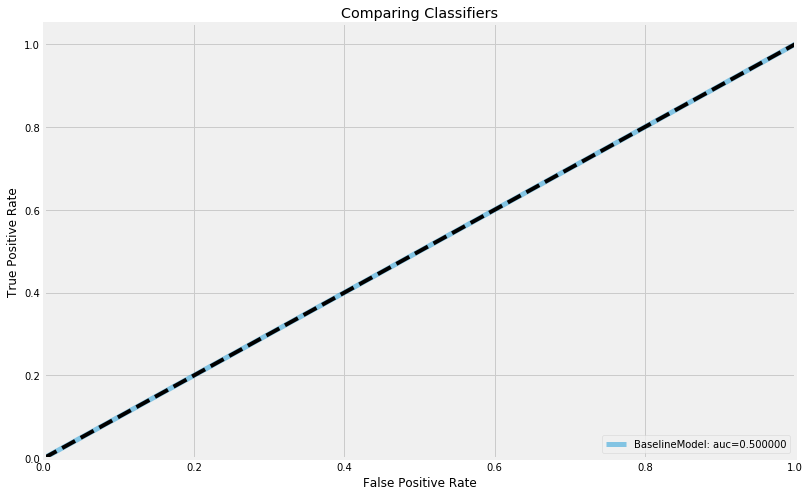

In [12]:
# Let's use Dummy Classifier from sklearn library as a baseline model
from sklearn.dummy import DummyClassifier

# Packages needed for this section 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Call classification function for dummy classifier
dor0 = make_classifications({'BaselineModel': ('-', DummyClassifier(strategy='most_frequent'))})

>Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. In our target variable we have total 146 True (Demented) subjects and 227 False (NonDemented) subjects. The curves above would be closer to point (1,1) for a perfect classifier. 
>
> Result suggests that we have not a good model such that the model has precision and recall scores of 0, when we set classification strategy as `most-frequent` class which always predicts the most frequent label in the training set. We could be loyal to class distribution in the training set by choosing our classification strategy as `stratified`. The first method is more human-way of thinking or generalizing so we chose to go with that.
> 
> The diagnostic odds ratio is undefined when the number of false negatives or false positives is zero – if both false negatives and false positives are zero, then the test is perfect, but if only one is, this ratio does not give a usable measure. The typical response to such a scenario is to add 0.5 to all cells in the contingency table,[1][6] although this should not be seen as a correction as it introduces a bias to results.[4] It is suggested that the adjustment is made to all contingency tables, even if there are no cells with zero entries.[Taken from Wikipedia](https://en.wikipedia.org/wiki/Diagnostic_odds_ratio)

<a href='#top' id='linearmodels'>back to menu</a>

### Linear Classifiers

> We will test out linear models listed below:
- **Logistic Regression**
    - Pros: Logistic regression is designed for this purpose (classification), and is most useful for understanding the influence of several independent variables on a single outcome variable.
    - Cons :  Works only when the predicted variable is binary, assumes all predictors are independent of each other, and assumes data is free of missing values.
- **Linear Discriminant Analysis**
    - A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
    - The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix.
    - The fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on training: 0.804 with using LogisticRegression
Accuracy on testing: 0.7804878048780488 with using LogisticRegression
              precision    recall  f1-score   support

 NonDemented       0.74      0.99      0.85        75
    Demented       0.96      0.46      0.62        48

   micro avg       0.78      0.78      0.78       123
   macro avg       0.85      0.72      0.73       123
weighted avg       0.82      0.78      0.76       123

DOR Score:  62.61538461538461
------------------------
Accuracy on training: 0.84 with using LinearDiscriminantAnalysis
Accuracy on testing: 0.7317073170731707 with using LinearDiscriminantAnalysis
              precision    recall  f1-score   support

 NonDemented       0.71      0.96      0.81        75
    Demented       0.86      0.38      0.52        48

   micro avg       0.73      0.73      0.73       123
   macro avg       0.78      0.67      0.67       123
weighted avg       0.76      0.73      0.70       123

DOR Score:  14.39999

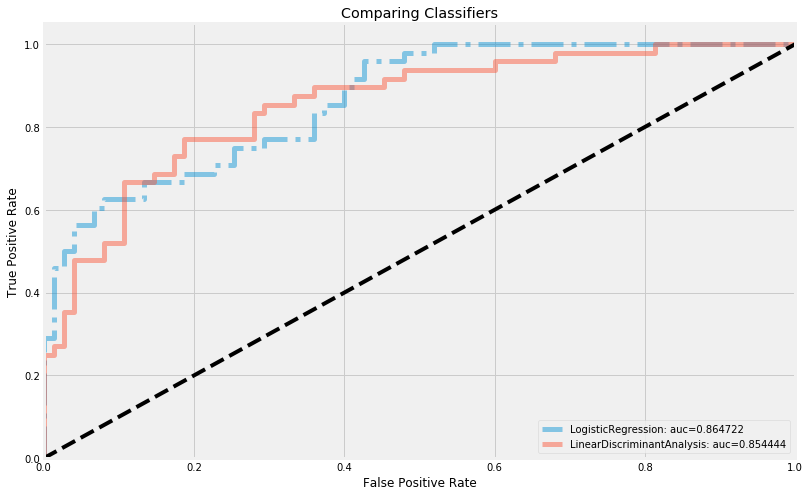

In [14]:
# Packages needed for this section 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Define Classifiers
linear_clfs = {
    'LogisticRegression' : ('-.', LogisticRegression()),
    'LinearDiscriminantAnalysis' : ('-', LinearDiscriminantAnalysis())
}

# Call Linear Classifiers assign DOR score handler
dor1 = make_classifications(linear_clfs)

<a href='#top' id='nonlinearmodels'>back to menu</a>

### Non-Linear Classifiers


> We will test out models listed below: 
- **Neural Networks(MLPC)**
    - Multi-layer Perceptron classifier.
    - This model optimizes the log-loss function using LBFGS or stochastic gradient descent.
- **SVM** 
    - Effective in high dimensional spaces and uses a subset of training points in the decision function so it is also memory efficient.
    - The algorithm does not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.
- **Naive Bayes**
    - This algorithm requires a small amount of training data to estimate the necessary parameters. Naive Bayes classifiers are extremely fast compared to more sophisticated methods.
    - Naive Bayes is is known to be a bad estimator. 

Accuracy on training: 0.744 with using NeuralNetworks
Accuracy on testing: 0.6910569105691057 with using NeuralNetworks
              precision    recall  f1-score   support

 NonDemented       0.72      0.81      0.76        75
    Demented       0.63      0.50      0.56        48

   micro avg       0.69      0.69      0.69       123
   macro avg       0.67      0.66      0.66       123
weighted avg       0.68      0.69      0.68       123

DOR Score:  4.357142857142857
------------------------
Accuracy on training: 0.876 with using SVMClassifier
Accuracy on testing: 0.7642276422764228 with using SVMClassifier
              precision    recall  f1-score   support

 NonDemented       0.76      0.91      0.82        75
    Demented       0.79      0.54      0.64        48

   micro avg       0.76      0.76      0.76       123
   macro avg       0.77      0.72      0.73       123
weighted avg       0.77      0.76      0.75       123

DOR Score:  11.48051948051948
-----------------------

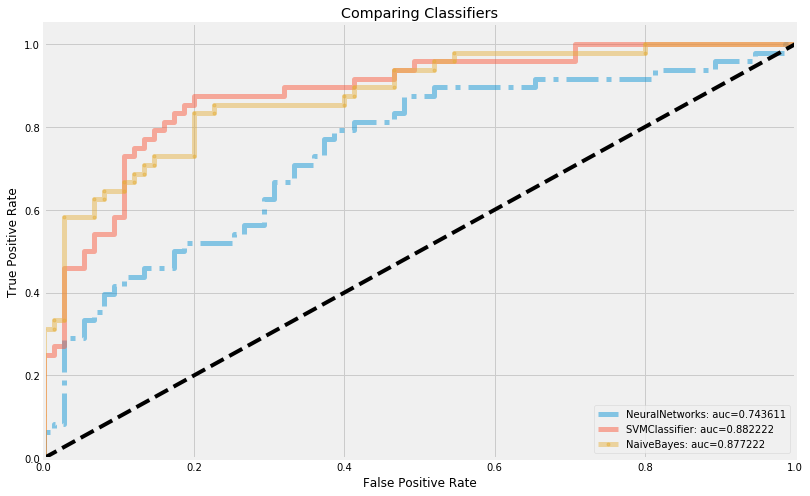

In [13]:
# Packages needed for this section 
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Define Classifiers
non_linear_classifers = {
    'NeuralNetworks' : ('-.', MLPClassifier()),
    'SVMClassifier' : ('-', SVC(kernel='linear', probability=True)), # Enable Prob estimates
    'NaiveBayes'    : ('.-', GaussianNB())
}

# Call Linear Classifiers
dor2 = make_classifications(non_linear_classifers)

<a href='#top' id='treemodels'>back to menu</a>

### Tree Based Classifiers

> We will test out models listed below:
- **Basic Decision Tree**
    - Decision Tree is simple to understand and visualise, requires little data preparation, and can handle both numerical and categorical data. 
    - Do not suffer from collinearity as linear models do.
    - Decision tree can create complex trees that do not generalise well, and decision trees can be unstable because small variations in the data might result in a completely different tree being generated.
- **Random Forest Classifier**
    - Reduction in over-fitting and random forest classifier is more accurate than decision trees in most cases.
    - Slow real time prediction, difficult to implement, and complex algorithm.
- **Boosting Classifiers**
    - Gradient Boosting: GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions.
    - XGBoost : This implements gradient boosted decision trees, and scales very well to many samples. It works by iteratively learning a set of weak models on subsets of the data, weighing each weak prediction according to each weak model's performance, and combining the weighted predictions to obtain a single weighted prediction.
    -  XGBoost internally has parameters for cross-validation, regularization, user-defined objective functions, missing values, tree parameters, scikit-learn compatible API etc

Accuracy on training: 1.0 with using DecisionTree
Accuracy on testing: 0.7154471544715447 with using DecisionTree
              precision    recall  f1-score   support

 NonDemented       0.75      0.80      0.77        75
    Demented       0.65      0.58      0.62        48

   micro avg       0.72      0.72      0.72       123
   macro avg       0.70      0.69      0.69       123
weighted avg       0.71      0.72      0.71       123

DOR Score:  5.6000000000000005
------------------------
Accuracy on training: 0.988 with using RandomForest
Accuracy on testing: 0.7723577235772358 with using RandomForest
              precision    recall  f1-score   support

 NonDemented       0.76      0.92      0.83        75
    Demented       0.81      0.54      0.65        48

   micro avg       0.77      0.77      0.77       123
   macro avg       0.79      0.73      0.74       123
weighted avg       0.78      0.77      0.76       123

DOR Score:  13.590909090909092
------------------------
Accu

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


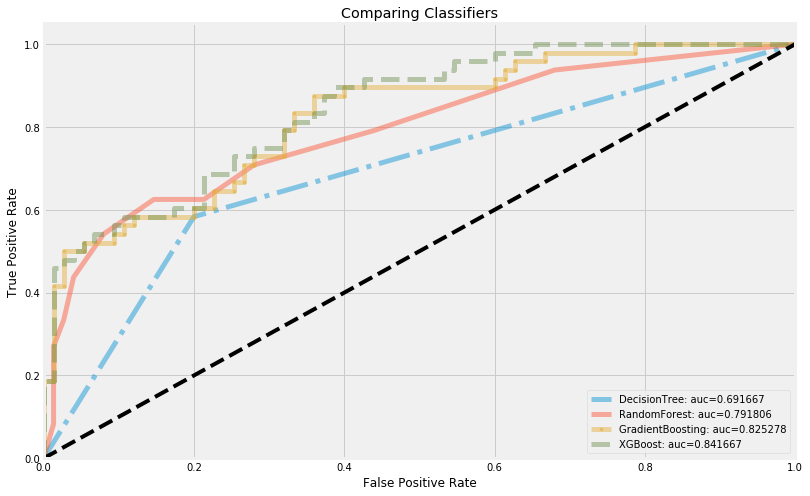

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

tree_based_classifiers = {
    'DecisionTree'     : ('-.', DecisionTreeClassifier()),
    'RandomForest'     : ('-', RandomForestClassifier()), # Enable Prob estimates
    'GradientBoosting' : ('.-', GradientBoostingClassifier()),
    'XGBoost'          : ('--', XGBClassifier())
}

# Call Linear Classifiers
dor3 = make_classifications(tree_based_classifiers)

<a href='#top' id='defaultmodels'>back to menu</a>

## Best Models with Default Parameters

In [19]:
# Merge DOR scores from all models (Credit for the function https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression)
def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

all_dor_scores = merge_dicts(dor0, dor1, dor2, dor3)

# Let's display them in a table for comparison
score_table = pd.DataFrame(data=[all_dor_scores[k] for k in all_dor_scores],
                           columns=['Diagnostic_Odds_Ratio', 'Training_Accuracy', 'Test_Accuracy'],
                           index=[key for key in all_dor_scores.keys()]
                          )
score_table.sort_values(by='Diagnostic_Odds_Ratio')

,Diagnostic_Odds_Ratio,Training_Accuracy,Test_Accuracy
BaselineModel,1.562499,0.608,0.609756
NeuralNetworks,1.595588,0.532,0.536585
DecisionTree,5.600000,1.000,0.715447
GradientBoosting,9.428571,0.996,0.756098
SVMClassifier,11.480519,0.876,0.764228
XGBoost,11.480519,0.996,0.764228
RandomForest,13.590909,0.988,0.772358
LinearDiscriminantAnalysis,14.400000,0.840,0.731707
NaiveBayes,43.136364,0.856,0.804878
LogisticRegression,62.615385,0.804,0.780488


In [20]:
# We want to pick out three models that have largest DOR and Test Accuracy
score_table.nlargest(n=5,columns='Diagnostic_Odds_Ratio').nlargest(n=4, columns='Test_Accuracy')

,Diagnostic_Odds_Ratio,Training_Accuracy,Test_Accuracy
NaiveBayes,43.136364,0.856,0.804878
LogisticRegression,62.615385,0.804,0.780488
RandomForest,13.590909,0.988,0.772358
SVMClassifier,11.480519,0.876,0.764228


> First off, our models with default parameters were able to provide better performance than the baseline model. This is a sign for us to apply machine learning models and tecniques on this particular dataset to get better estimates for data. 
>
> What if a model overfits:
> - Try cross-validation
> - Train with more data
> - Remove some features that are irrelevant (looking at feature importance can help)
> - Early Stopping the iterations in learning phase
> - Regularization 
> - Ensembling : Bagging uses complex base models and tries to "smooth out" their predictions, while boosting uses simple base models and tries to "boost" their aggregate complexity.
>
> Looks like we have now overfitting problem with default models. In the next section we will look into that problem using GridSearch and Cross-Validation methodology.
> 
>GaussianNB is not requiring to do hyper parameter tuning so we pass the above results for GaussianNB to the next session.
>
>We have run three main set of classifiers and got our results like the table above. Now that models are picked out it is time to tune those models and get the best performing model among them.


<a href='#top' id='tuning'>back to menu</a>

## Perform Hyperparameter Tuning on The Best Models

In [21]:
 # Import necessary modules
from sklearn.model_selection import GridSearchCV, cross_val_score

# Tuning Function returns best_parameters
def tuning(regularizator):
    """
    This function apply hyperparameter tuning to machine learning algorithms with pca features and 
    returns best parameters, confusion matrix and f1 score which will be used in models comparison.
    """
    
    # Hyperparameter with regularizator
    clf = regularizator
    
    # Fitting classifier to the Training set (all features)
    clf.fit(x_train, y_train)
    
    # Print Best Scores
    print(("Best score:  {}".format(clf.best_score_))) # Mean CV score of the best estimator
    print("Best parameters set:")
    # estimator which gave highest score on the left out data
    best_parameters = clf.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
        print(("\t{}: {}".format(param_name, best_parameters[param_name])))
    
    # Accuracy
    training_accuracy = clf.score(x_train, y_train)
    test_accuracy = clf.score(x_test, y_test)
    print(("Accuracy on training data: {:2f}".format(training_accuracy)))
    print(("Accuracy on test data:     {:2f}".format(test_accuracy)))
    
    return best_parameters

### Tuning RandomForest

In [22]:
# Find the best parameters for RandomForestClassifier()
clf_to_tune = RandomForestClassifier()

print('The Best Paramters for RandomForest')
params= {
    'n_estimators' : [5, 25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800],
    'min_samples_leaf': [1, 6, 12, 24, 30],
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20]
}

# Get best_parameters to use
parameters_to = tuning(GridSearchCV(clf_to_tune,
                                   param_grid=params,
                                   scoring='balanced_accuracy',
                                   cv=5)) # f1 could be chosen
# save the resulting model
rfc = RandomForestClassifier(**parameters_to)

The Best Paramters for RandomForest
Best score:  0.8620282399547256
Best parameters set:
	criterion: entropy
	max_depth: 20
	min_samples_leaf: 12
	n_estimators: 5
Accuracy on training data: 0.875269
Accuracy on test data:     0.712917


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy on training: 0.888 with using RandomForest
Accuracy on testing: 0.8048780487804879 with using RandomForest
              precision    recall  f1-score   support

 NonDemented       0.77      0.96      0.86        75
    Demented       0.90      0.56      0.69        48

   micro avg       0.80      0.80      0.80       123
   macro avg       0.84      0.76      0.77       123
weighted avg       0.82      0.80      0.79       123

DOR Score:  30.857142857142854
------------------------


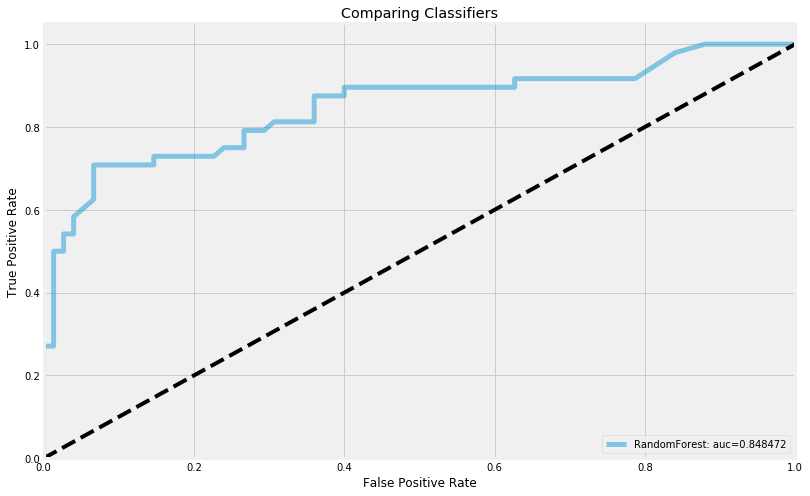

In [23]:
dor_rf = make_classifications({
                        'RandomForest': ('-',
                                         RandomForestClassifier(**parameters_to))
})

### Tuning XGBoost

In [42]:
# Find the best parameters for XGBoost()
clf_to_tune = XGBClassifier(booster='gbtree',
                           objective='binary:logistic',)

params = {
    'max_depth': [3, 9, 27, 81, 243],
    'n_estimators': [5, 25, 125, 625],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.25, 0.5, 0.75, 1],
    'gamma': [.0, .1, .2, .3, .4],
    'reg_alpha': [1e-5, 1e-2, .1, 1, 100],
    
}

# Get best_parameters to use
parameters_to = tuning(GridSearchCV(clf_to_tune,
                                   param_grid=params,
                                   scoring='balanced_accuracy',
                                   cv=5))

# Save the resulting model
xgboost = XGBClassifier(**parameters_to)

Best score:  0.8757685908319184
Best parameters set:
	colsample_bytree: 0.25
	gamma: 0.3
	max_depth: 3
	min_child_weight: 5
	n_estimators: 625
	reg_alpha: 0.1
Accuracy on training data: 0.956230
Accuracy on test data:     0.771667


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy on training: 0.96 with using XGBoost
Accuracy on testing: 0.8130081300813008 with using XGBoost
              precision    recall  f1-score   support

 NonDemented       0.78      0.96      0.86        75
    Demented       0.90      0.58      0.71        48

   micro avg       0.81      0.81      0.81       123
   macro avg       0.84      0.77      0.79       123
weighted avg       0.83      0.81      0.80       123

DOR Score:  33.6
------------------------


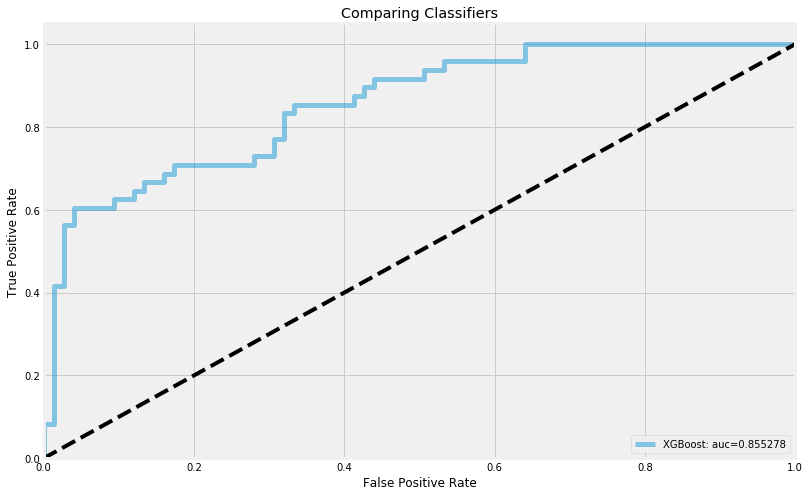

In [43]:
dor_xgb = make_classifications({
                                'XGBoost': ('-',
                                           XGBClassifier(**parameters_to))
})

### Cross-Validation GNBayes

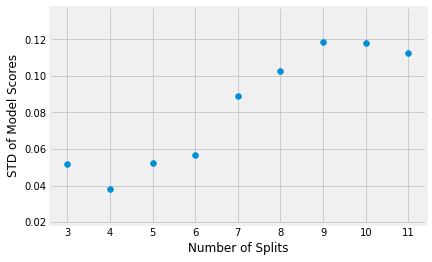

In [70]:
from sklearn.model_selection import cross_val_score

scores_std = []
for i in range(3,12):
    clf = GaussianNB()
    scores = cross_val_score(clf, x_train, y_train, cv=i)
    scores_std.append(scores.std())
    
ind = np.arange(3, 12)
plt.scatter(ind, scores_std)
plt.xlabel('Number of Splits')
plt.ylabel('STD of Model Scores');

In [71]:
scores = cross_val_score(clf, x_train, y_train, cv=4)
scores

array([0.84126984, 0.84126984, 0.77419355, 0.75806452])

### Tuning SVC 

In [72]:
# Parameter c: low c makes the decision surface smooth
# high c aims at classifying all samples correctly (can be wiggly)
# gamma defines how much influence a single training sample has

clf_to_tune = SVC(gamma='scale', probability=True)

params = {
    'kernel': ('linear', 'rbf'),
    'C' : [.01, 1, 10],
}

parameters_to = tuning(GridSearchCV(clf_to_tune,
                                   param_grid=params,
                                   scoring='balanced_accuracy',
                                   cv=5))
# save the resulting model
svm = SVC(**parameters_to)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score:  0.8553852292020374
Best parameters set:
	C: 10
	kernel: linear
Accuracy on training data: 0.866541
Accuracy on test data:     0.754583


Accuracy on training: 0.884 with using SVC
Accuracy on testing: 0.7967479674796748 with using SVC
              precision    recall  f1-score   support

 NonDemented       0.77      0.95      0.85        75
    Demented       0.87      0.56      0.68        48

   micro avg       0.80      0.80      0.80       123
   macro avg       0.82      0.75      0.77       123
weighted avg       0.81      0.80      0.79       123

DOR Score:  22.821428571428573
------------------------


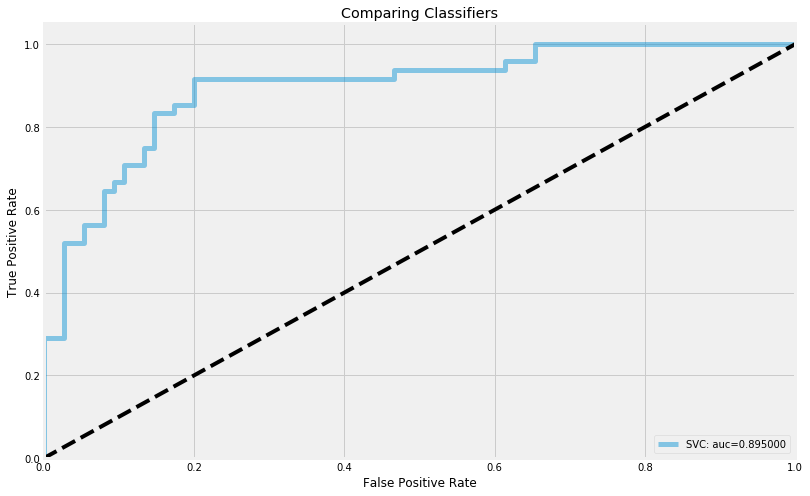

In [73]:
dor_svc = make_classifications({
                               'SVC':(
                                     '-',
                                     SVC(**parameters_to))
})

### Tuning LogisticRegression

In [97]:
# Logistic Regression parameter tuning
# c for regularization strength
clf_to_tune = LogisticRegression(max_iter=10000) # good solver for small dataset

params = {
    'solver' : ['liblinear', 'lbfgs'],
    'C': [.0001, .0001, .001, .01, 1, 10, 100],
}

parameters_to = tuning(GridSearchCV(clf_to_tune,
                                   param_grid=params,
                                   scoring='balanced_accuracy',
                                   cv=5))
# save the resulting model
logreg = LogisticRegression(**parameters_to)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score:  0.8518176570458406
Best parameters set:
	C: 1
	solver: lbfgs
Accuracy on training data: 0.875269
Accuracy on test data:     0.744167


> Reminder: For small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C, we lower the power of regularization which imples the model is allowed to increase it's complexity, and therefore, overfit the data.¶

Accuracy on training: 0.888 with using LogisticReg
Accuracy on testing: 0.7886178861788617 with using LogisticReg
              precision    recall  f1-score   support

 NonDemented       0.76      0.95      0.85        75
    Demented       0.87      0.54      0.67        48

   micro avg       0.79      0.79      0.79       123
   macro avg       0.82      0.74      0.76       123
weighted avg       0.80      0.79      0.78       123

DOR Score:  20.97727272727273
------------------------


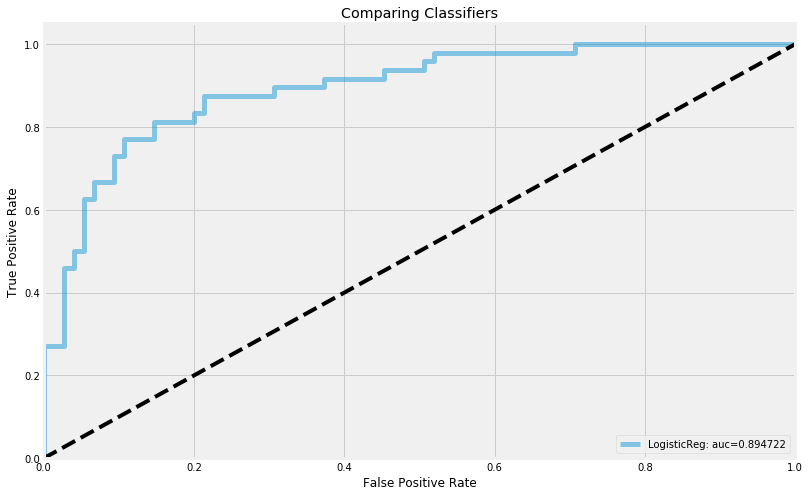

In [98]:
# Show results for Logistic Regression
dor_logistic = make_classifications(
                                    {'LogisticReg': ('-',
                                                    LogisticRegression(**parameters_to))}
)

### Compare Results After Hyperparameter Tuning

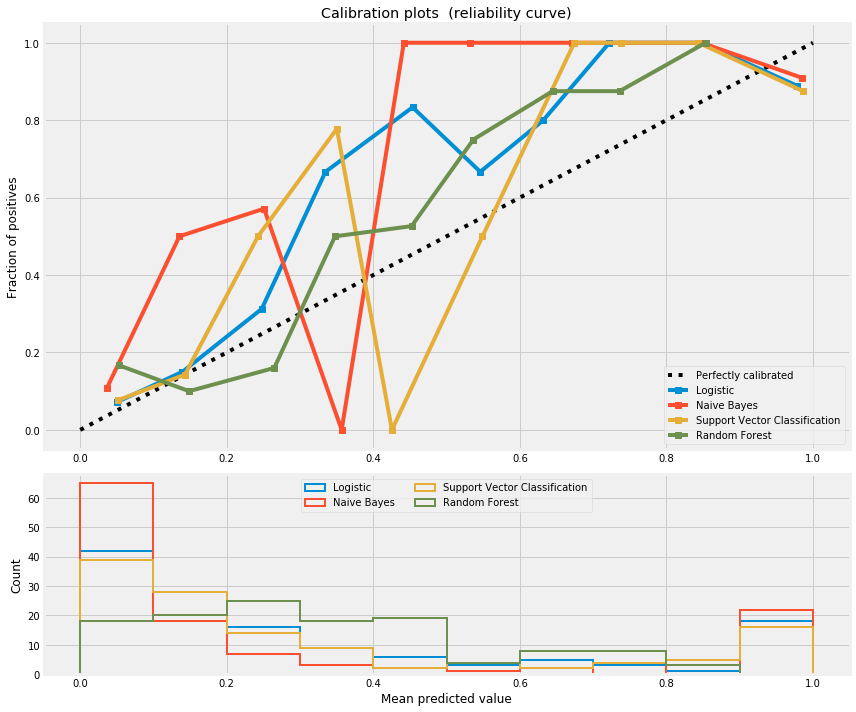

In [99]:
from sklearn.calibration import calibration_curve

gnb = GaussianNB()
# Plot calibration plots

plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(logreg, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svm, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(x_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(x_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(x_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

> Mean Predicted Value plot shows that majority of the models predicted near 0 which is Non-Demented. That might be because of high proportion of Non-Demented cases in our dataset. It can be seen in Baseline Model.

In [102]:
# Merge DOR scores from all models (Credit for the function https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression)
def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result
# Get GNBayes dor metric from previous section
dor_gnb = {'GaussianNB': dor2['NaiveBayes']}

# Merger for results of the three models
best_model_dors = merge_dicts(dor_rf, dor_svc, dor_gnb, dor_logistic, dor_xgb)

# Let's display them in a table for comparison
score_table = pd.DataFrame(data=[best_model_dors[k] for k in best_model_dors],
                           columns=['Diagnostic_Odds_Ratio', 'Training_Accuracy', 'Test_Accuracy'],
                           index=[key for key in best_model_dors.keys()]
                          )
score_table.sort_values(by='Diagnostic_Odds_Ratio')

,Diagnostic_Odds_Ratio,Training_Accuracy,Test_Accuracy
LogisticReg,20.977273,0.888,0.788618
SVC,22.821429,0.884,0.796748
RandomForest,30.857143,0.888,0.804878
XGBoost,33.600000,0.960,0.813008
GaussianNB,43.136364,0.856,0.804878


In [103]:
 score_table.nlargest(columns='Diagnostic_Odds_Ratio', n=1)

,Diagnostic_Odds_Ratio,Training_Accuracy,Test_Accuracy
GaussianNB,43.136364,0.856,0.804878


> The winning model is Gaussian Naive Bayes classification model with higher test Accuracy and the Diagnostic Odds Ratio metric and also with lower over fit. It is computaionally almost the least expensive model! 

<a href='#top' id='bestmodel'>back to menu</a>

## Evaluate the Best Model on Testing Set

In [14]:
from sklearn.metrics import accuracy_score

# Compare Baseline and Final model 
base_model = DummyClassifier(strategy='most_frequent')
base_model.fit(x_train, y_train) 
base_pred = base_model.predict(x_test)

final_model = GaussianNB()
final_model.fit(x_train, y_train)
final_pred = final_model.predict(x_test)

base_accuracy = accuracy_score(y_test, base_pred)
print(f'Base Accuracy {base_accuracy}')

final_accuracy = accuracy_score(y_test, final_pred)
print(f'GaussianNB Accuracy {final_accuracy}')

Base Accuracy 0.6097560975609756
GaussianNB Accuracy 0.8048780487804879


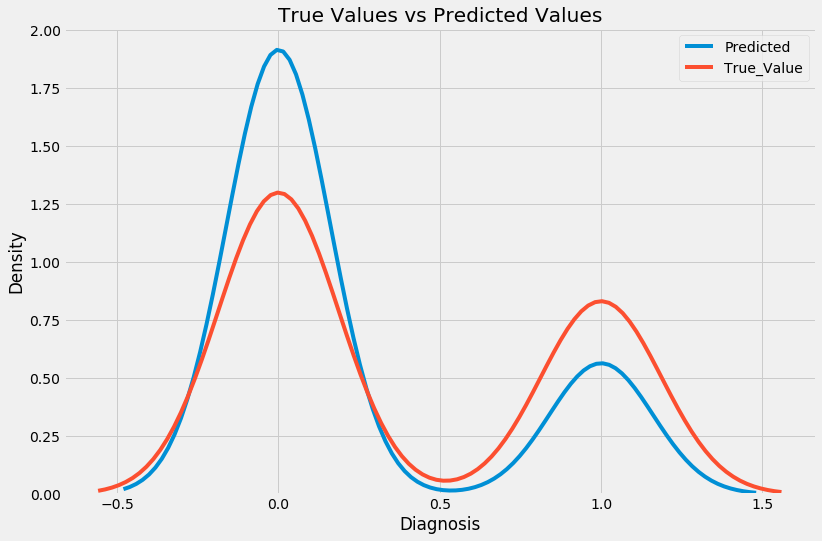

In [15]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12,8))

sns.kdeplot(final_pred, label='Predicted')
sns.kdeplot(y_test, label='True_Value');
ax.set_xlabel('Diagnosis')
ax.set_ylabel('Density')
ax.set_title('True Values vs Predicted Values')
plt.savefig('NaiveBayes.png');

> This plot agrees results from Mean Predicted Count Plots in previous section. Model affected by number of Non-Demented observations so it predicts more Non-Demented than Demented as expected.

In [121]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    true, preds = 1*y_true, 1*y_pred
    return np.mean(abs(true - preds))
print(f'The absolute error of GNB : {mae(y_test, final_pred)}')

The absolute error of GNB : 0.1951219512195122


In [125]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    true, preds = 1*y_true, 1*y_pred
    return np.mean(abs(true - preds))
print(f'The absolute error of BaseModel : {mae(y_test, base_pred)}')

The absolute error of BaseModel : 0.3902439024390244


In [130]:
# Classification report
target_names = ['NonDemented', 'Demented']
print(classification_report(y_test, final_pred, target_names=target_names))

              precision    recall  f1-score   support

 NonDemented       0.77      0.97      0.86        75
    Demented       0.93      0.54      0.68        48

   micro avg       0.80      0.80      0.80       123
   macro avg       0.85      0.76      0.77       123
weighted avg       0.83      0.80      0.79       123



In [133]:
# Classification report
target_names = ['NonDemented', 'Demented']
print(classification_report(y_test, base_pred, target_names=target_names))

              precision    recall  f1-score   support

 NonDemented       0.61      1.00      0.76        75
    Demented       0.00      0.00      0.00        48

   micro avg       0.61      0.61      0.61       123
   macro avg       0.30      0.50      0.38       123
weighted avg       0.37      0.61      0.46       123



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [135]:
# Merge DOR scores from all models (Credit for the function https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression)
def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result
# Get GNBayes dor metric from previous section
dor_gnb = {'GaussianNB': dor2['NaiveBayes']}

# Merger for results of the three models
best_model_dors = merge_dicts(dor0, dor_gnb)

# Let's display them in a table for comparison
score_table = pd.DataFrame(data=[best_model_dors[k] for k in best_model_dors],
                           columns=['Diagnostic_Odds_Ratio', 'Training_Accuracy', 'Test_Accuracy'],
                           index=[key for key in best_model_dors.keys()]
                          )
score_table.sort_values(by='Diagnostic_Odds_Ratio')

,Diagnostic_Odds_Ratio,Training_Accuracy,Test_Accuracy
BaselineModel,1.562499,0.608,0.609756
GaussianNB,43.136364,0.856,0.804878


<a href='#top' id='interpretation'>back to menu</a>

## Interpret the Model Results

> To compare models, two performance metric were used even though more than two were shown. The frist metric is used DOR Diagnostic Odds Ratio score which measures effectiveness of a diagnostic test. Second metric is used Accuracy score on test set. We first choose top 3 models with the highest DOR score than compare Accuracy Scores among those selected ones.
>
> Two step model selection process is applied. In the first phase we ranked models with default parameter settings then picked out 4 successful models based on our metrics. In the second phase hyper parameter tuning with GridSearch algorithm is applied and the rest of selection process took place as before.  
>
> The results showed us that machine learning is applicable to our problem. GNB model with default parameters out-performed all other models with best set of hyper-parameters we have tested above. 
>
> The final model (GNB) has done good job on improving classification error by almost $\%20$ compared to Base Model. It has DOR score of 43 which is the highest among all other models. DOR score ranges from 0 to infinity, although for useful tests it is greater than 1, and higher socres are indication of better test performance. With more data, results would be more reliable. For instance with diverse data that subject with specific characteristics is more likely to be be diagnosed with Dementia based on information from other subjects with the same characteristics.
>
>
>Since Alzheimer’s is increasingly understood as a disease that spans many years, with biological changes occurring decades prior to symptom onset, more specific data should be collected to reflect after and before cases of subjects along with overall health condition of subjects to create better decision making models. Also educating the public about brain health and cognitive aging, and benefits of early detection of dementias would help collecting more diverse data.

<a href='#top' id='conclusion'>back to menu</a>

[Back To EDA]()